In [11]:
# pip install matplotlib

In [12]:
import json, time, pathlib
import matplotlib.pyplot as plt

from pprint import pprint

import sklearn.datasets
import sklearn.metrics

import autosklearn.classification


In [13]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

In [14]:
log_path = pathlib.Path("autoskl_runs.jsonl")
fh = log_path.open("a", buffering=1)

def grava_json(smbo, run_info, result, time_left):
    """É chamado após cada configuração terminar.

    - NÃO pode demorar: mantenha só operações rápidas.
    - Retorna None → SMAC continua normalmente.
    """
    # 1) Extrai o dict puro da configuração
    try:
        config_dict = run_info.config.get_dictionary()
    except AttributeError:
        config_dict = dict(run_info.config.values())

    # 2) Desserializa o JSON de 'instance' (se vier como string JSON)
    raw_instance = run_info.instance
    try:
        instance_obj = json.loads(raw_instance)
    except (TypeError, ValueError):
        instance_obj = raw_instance

    registro = {
        "timeStamp": time.time(),
        "time_left": time_left,
        "score": 1 - result.cost,
        "status": result.status.name,
        "duration": result.time,
        "run_info": {
            "config": config_dict,
            "instance": instance_obj,              
            "instance_specific": run_info.instance_specific,
            "seed": run_info.seed,
            "cutoff": run_info.cutoff,
            "capped": run_info.capped,
            "budget": run_info.budget,
            "source_id": run_info.source_id
        }
    }

    # Escreve uma linha JSON e força gravação imediata
    json.dump(registro, fh, separators=(',', ':'))  # sem espaços extras
    fh.write("\n")
    fh.flush()

In [15]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    tmp_folder="without_ensemble_tmp",
    # get_trials_callback= grava_json,
    ensemble_size=1
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

/tmp/ipykernel_8896/4182698864.py:1: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 1}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
  automl = autosklearn.classification.AutoSklearnClassifier(


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      ensemble_kwargs={'ensemble_size': 1}, ensemble_size=1,
                      per_run_time_limit=12, time_left_for_this_task=120,
                      tmp_folder='without_ensemble_tmp')

/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(


<Axes: xlabel='Timestamp'>

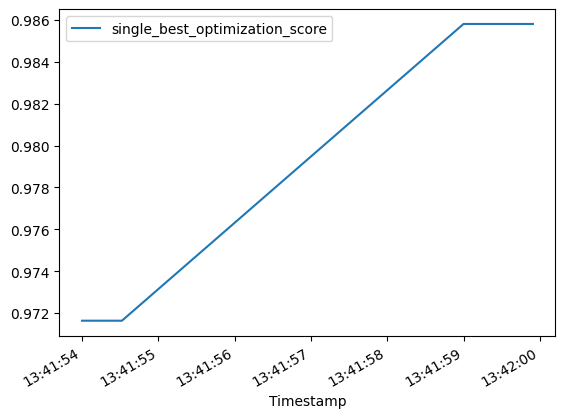

In [16]:
df = automl.performance_over_time_
df.plot(x='Timestamp', y='single_best_optimization_score', kind='line')

In [17]:
df

,Timestamp,ensemble_optimization_score,single_best_optimization_score,single_best_train_score
0,2025-07-06 13:41:54.000000,NaN,0.971631,1.0
1,2025-07-06 13:41:54.000000,NaN,0.971631,1.0
2,2025-07-06 13:41:54.523120,0.971631,0.971631,1.0
3,2025-07-06 13:41:54.523120,0.971631,0.971631,1.0
23,2025-07-06 13:41:59.000000,0.971631,0.985816,1.0
...,...,...,...,...
51,2025-07-06 13:41:59.909685,0.985816,0.985816,1.0
52,2025-07-06 13:41:59.909685,0.985816,0.985816,1.0
53,2025-07-06 13:41:59.909685,0.985816,0.985816,1.0
55,2025-07-06 13:41:59.909685,0.985816,0.985816,1.0


In [18]:
print(automl.leaderboard())

          rank  ensemble_weight         type      cost  duration
model_id                                                        
7            1              1.0  extra_trees  0.014184  1.102374


In [19]:
pprint(automl.show_models(), indent=4)

{   7: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7234077a6af0>,
           'cost': 0.014184397163120588,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7234077b6c40>,
           'ensemble_weight': 1.0,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x72340781d700>,
           'model_id': 7,
           'rank': 1,
           'sklearn_classifier': ExtraTreesClassifier(max_features=34, min_samples_leaf=3, min_samples_split=11,
                     n_estimators=512, n_jobs=1, random_state=1,
                     warm_start=True)}}


In [20]:
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score: 0.9440559440559441
